# Simulated Annealing TSP

In [23]:
import pandas as pd

In [24]:
def load_nodes(path):
    df=pd.read_csv(path)
    df.rename({'X':'lon','Y':'lat'},axis='columns',inplace=True)
    return df

def load_data(path):
    df=pd.read_csv(path, encoding = 'utf-8',dtype={'InputID':'string','TargetID':'string','Distance':float}) 
    df['InputID'] = df['InputID'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    df['TargetID'] = df['TargetID'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    #df['TargetID']=df['TargetID'].astype('category')
    #df['InputID']=df['InputID'].astype('category')
    return df

In [3]:
dist_path='data/distancias_maule.csv'
edge_data=load_data(dist_path)
nodes_path='data/comunas_maule.csv'
node_data=load_nodes(nodes_path)

In [25]:
node_data.head()

,lon,lat,Z,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia
0,-71.953081,-35.129891,0,279,191493.545385,17,9,7103,7,1.602501e+09,234347.693056,Región del Maule,Curepto,Talca
1,-72.284260,-35.613610,0,280,142724.349430,17,9,7104,7,8.575285e+08,175634.266010,Región del Maule,Empedrado,Talca
2,-71.816301,-35.327665,0,283,176274.410596,17,9,7107,7,1.437081e+09,216188.830744,Región del Maule,Pencahue,Talca
3,-71.331995,-35.958516,0,271,288033.759891,18,9,7401,7,2.245999e+09,356106.042176,Región del Maule,Linares,Linares
4,-71.441142,-36.110871,0,272,267604.712137,18,9,7403,7,2.231920e+09,331498.941045,Región del Maule,Longaví,Linares


In [39]:
edge_data.iloc[1]

InputID          Curepto
TargetID           Rauco
Distance    52563.813577
Name: 1, dtype: object

In [47]:
import numpy as np
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r *1000

In [48]:
get_lon_lat = lambda comuna : node_data[node_data['Comuna']==comuna][['lon','lat']].values[0]

In [49]:
p1=get_lon_lat('Curepto')
p2=get_lon_lat('Rauco')

In [50]:
haversine(p1[0], p1[1], p2[0], p2[1])

52485.881620759625

In [51]:
import numpy as np
from heapq import heappush,heappop

class abstract_graph:
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges} | {v for u,v in self.edges}
        
    def adjacency_matrix(self):
        pass
    
    def adjacency_list(self):
        pass

    
class simple_graph(abstract_graph):
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges if u==n } | {u for u,v in self.edges if v==n}
        return {v:adjacent(v) for v in self.nodes}
    

    
class weighted_graph(abstract_graph):
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges.keys()} | {v for u,v in self.edges.keys()}
        
    def adjacency_matrix(self):
        n=len(self.nodes)
        mat=np.zeros((n,n))
        adjacent=lambda x : [1 if x==v else 0 for (u,v) in enumerate(sorted(list(G.nodes))) ]
        L=self.adjacency_list()
        i=0
        for v in sorted(list(G.nodes)):
            for l in L[v]:
                mat[i,]+=adjacent(l)
            i=i+1
        return mat
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges.keys() if u==n } | {u for u,v in self.edges if v==n}
        return {v:adjacent(v) for v in self.nodes}

class weighted_digraph(abstract_graph):
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges.keys()} | {v for u,v in self.edges.keys()}
        
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges.keys() if u==n } 
        return {v:adjacent(v) for v in self.nodes}

In [52]:
import heapq

def prim_mst(graph,start):
    pq, path = [], []
    tree=[]
    heappush(pq, (0, start))
    adjacency=graph.adjacency_list()
    while pq:
        i,vertex=heappop(pq)
        if vertex in path:
            continue
        print('Vertice : {0}, Prioridad {1}'.format(vertex,i))
        path.append(vertex)
        for neighbor in adjacency[vertex]:
            if neighbor not in path:
                if (vertex,neighbor) in graph.edges:
                    heappush(pq, (graph.edges[(vertex,neighbor)], neighbor))
                    tree.append((vertex,neighbor))
                else:
                    heappush(pq, (graph.edges[(neighbor,vertex)], neighbor))
                    tree.append((neighbor,vertex))
    return tree

In [53]:
E={}
for index, row in edge_data.iterrows():
    E.update({(str(row['InputID']), str(row['TargetID'])):row['Distance']/1000})


In [58]:
G=weighted_graph(E)

In [59]:
T=prim_mst(G,'Talca')

Vertice : Talca, Prioridad 0
Vertice : Maule, Prioridad 13.3588466706527
Vertice : San Rafael, Prioridad 16.6889646628228
Vertice : Pelarco, Prioridad 16.3772167529705
Vertice : Ro Claro, Prioridad 15.4509736161126
Vertice : Villa Alegre, Prioridad 19.777915813341
Vertice : Yerbas Buenas, Prioridad 12.6247735177256
Vertice : Sagrada Familia, Prioridad 22.0322916541346
Vertice : Rauco, Prioridad 19.445741760600598
Vertice : Pencahue, Prioridad 22.274137574075098
Vertice : San Javier, Prioridad 22.941289943907798
Vertice : Curepto, Prioridad 25.2287371519794
Vertice : Licantn, Prioridad 19.8494699247521
Vertice : Vichuqun, Prioridad 15.1272469654501
Vertice : Huala, Prioridad 25.6595723154263
Vertice : Empedrado, Prioridad 32.3928762302954
Vertice : Chanco, Prioridad 20.518050594675998
Vertice : Pelluhue, Prioridad 26.0556688641867
Vertice : Constitucin, Prioridad 27.7777067275961
Vertice : Cauquenes, Prioridad 30.239877318467
Vertice : Molina, Prioridad 34.3081934822903
Vertice : Curic,

In [60]:
v=np.sum([G.edges[t] for t in T])
print('Prim MST valor : {0:0.2f}'.format(v))

Prim MST valor : 35800.90


# Simulated Annealing

https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md

__function__ SIMULATED-ANNEALING(_problem_,_schedule_) __returns__ a solution state  

&emsp;_current_ &larr; _problem_.INITIAL\-STATE  
&emsp;__for__ _t_ = 1 __to__ &infin;  __do__  
&emsp;&emsp;&emsp;_T_ &larr; _schedule(t)_  
&emsp;&emsp;&emsp;__if__ _T_ = 0 __then return__ _current_  
&emsp;&emsp;&emsp;_next_ &larr; a randomly selected successor of _current_  
&emsp;&emsp;&emsp;_&Delta;E_ &larr; VALUE(_next_) - VALUE(_current_)  
&emsp;&emsp;&emsp;__if__ _&Delta;E_ > 0 __then__ _current_ &larr; _next_  
&emsp;&emsp;&emsp;__else__ _current_ &larr; _next_ only with probability e<sup>_&Delta;E_/_T_</sup>

In [101]:
import numpy as np

current=np.random.permutation(list(G.nodes))
new=np.random.permutation(list(G.nodes))

In [102]:
current

array(['San Rafael', 'Villa Alegre', 'Pelluhue', 'Romeral', 'Constitucin',
       'San Clemente', 'Cauquenes', 'Molina', 'Curic', 'Talca', 'Curepto',
       'Huala', 'Vichuqun', 'Maule', 'Yerbas Buenas', 'Empedrado',
       'Sagrada Familia', 'Pencahue', 'Rauco', 'Chanco', 'Longav',
       'Ro Claro', 'San Javier', 'Teno', 'Retiro', 'Parral', 'Licantn',
       'Colbn', 'Pelarco', 'Linares'], dtype='<U15')

In [183]:
def make_cycle(current):
    C=list(zip(current[:-1],current[1:]))
    C.append((current[-1],current[0]))
    v=np.sum([G.edges[t] for t in C])
    return C,v/1000

In [189]:
k=0.9999
T=1.

current=np.random.permutation(list(G.nodes))
current_cycle,current_value=make_cycle(current)
epochs=10000
loss=[]
for i in range(epochs):
    new=np.random.permutation(list(G.nodes))
    next_cycle,next_value=make_cycle(new)
    delta = (current_value-next_value)
    if delta>0:
        current=new
    else:
        alpha=min(1,np.exp(delta/T))
        if alpha>np.random.random():
            current=new
            current_value=next_value
    T=k*T
    loss.append(current_value)
    

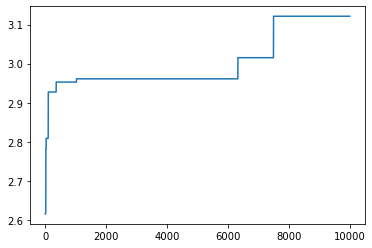

In [190]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.show()

In [186]:
current,current_value

(array(['Villa Alegre', 'Maule', 'Curepto', 'Retiro', 'San Rafael',
        'Linares', 'Licantn', 'Vichuqun', 'Ro Claro', 'Teno',
        'Constitucin', 'Huala', 'Parral', 'Longav', 'Colbn',
        'Sagrada Familia', 'Molina', 'San Clemente', 'Romeral',
        'Yerbas Buenas', 'San Javier', 'Pelluhue', 'Chanco', 'Empedrado',
        'Pelarco', 'Pencahue', 'Curic', 'Rauco', 'Cauquenes', 'Talca'],
       dtype='<U15'),
 3.014902350394983)

In [188]:
current,current_value

(array(['Villa Alegre', 'Maule', 'Curepto', 'Retiro', 'San Rafael',
        'Linares', 'Licantn', 'Vichuqun', 'Ro Claro', 'Teno',
        'Constitucin', 'Huala', 'Parral', 'Longav', 'Colbn',
        'Sagrada Familia', 'Molina', 'San Clemente', 'Romeral',
        'Yerbas Buenas', 'San Javier', 'Pelluhue', 'Chanco', 'Empedrado',
        'Pelarco', 'Pencahue', 'Curic', 'Rauco', 'Cauquenes', 'Talca'],
       dtype='<U15'),
 3.014902350394983)